<a href="https://colab.research.google.com/github/AbdullaK123/volIHWkCIdrhb8yc/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import random
from tensorflow.keras import Sequential, layers, optimizers, metrics, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

tf.random.set_seed(42)

train_path = '/content/drive/MyDrive/Project 4 Images/images/training'
test_path = '/content/drive/MyDrive/Project 4 Images/images/testing'
train_path_flip = '/content/drive/MyDrive/Project 4 Images/images/training/flip'
train_path_noflip = '/content/drive/MyDrive/Project 4 Images/images/training/notflip'

train_flip_imgs = [os.path.join(path, name) for path, subdirs, files in os.walk(train_path_flip) for name in files]
train_noflip_imgs = [os.path.join(path, name) for path, subdirs, files in os.walk(train_path_noflip) for name in files]
all_imgs = train_flip_imgs + train_noflip_imgs
random.shuffle(all_imgs)


train_val_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(rescale=1/255).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [3]:
print(len(train_path_flip))
print(len(train_path_noflip))

60
63


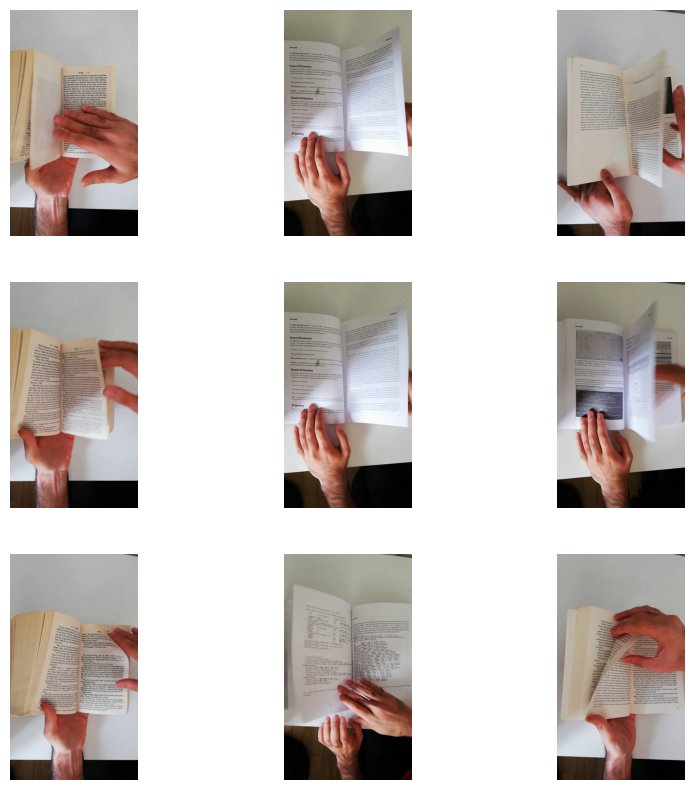

----------------------------------------------------------------------------------------------------


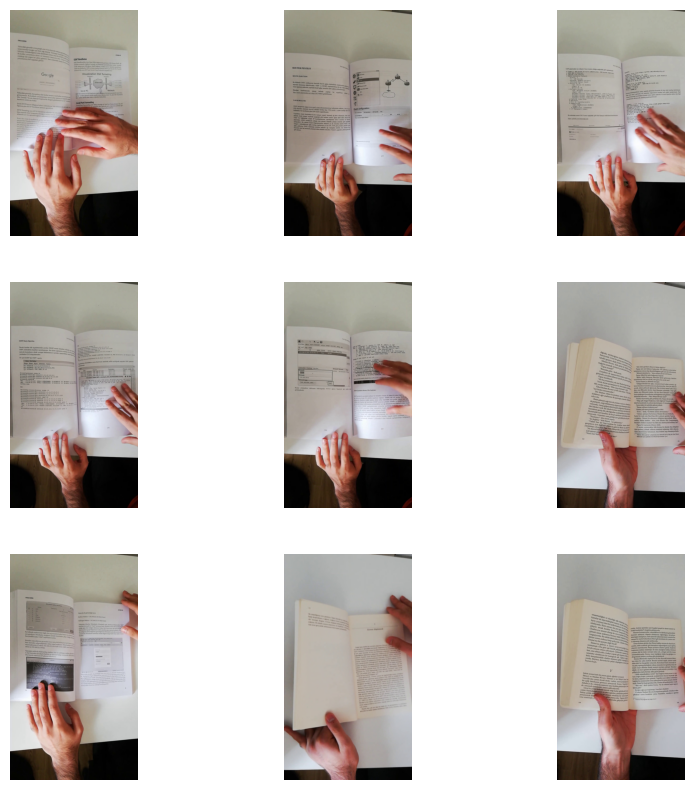

In [4]:

def plot_random_images(image_paths, grid_size=3):
  fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
  for i, ax in enumerate(axs.flatten()):
    img_path = random.choice(image_paths)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
  plt.show()

plot_random_images(train_flip_imgs)
print("-"*100)
plot_random_images(train_noflip_imgs)

In [5]:
def f1_score(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # Ensure correct data type
  y_pred = tf.cast(tf.round(y_pred), tf.float32)  # Threshold predictions to 0/1

  tp = tf.reduce_sum(y_true * y_pred)
  fp = tf.reduce_sum(y_pred * (1 - y_true))
  fn = tf.reduce_sum((1 - y_pred) * y_true)

  precision = tp / (tp + fp + tf.keras.backend.epsilon())
  recall = tp / (tp + fn + tf.keras.backend.epsilon())

  f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

  return f1

In [6]:
import warnings
warnings.filterwarnings('ignore')

model = Sequential(
    [
        layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            input_shape=(224, 224, 3)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │          93,314 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,834 (386.07 KB)

 Trainable params: 98,834 (386.07 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 785ms/step - f1_score: 0.5845 - loss: 0.7322 - val_f1_score: 0.5899 - val_loss: 0.7088
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 589ms/step - f1_score: 0.8336 - loss: 0.4280 - val_f1_score: 0.5835 - val_loss: 1.2194
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 561ms/step - f1_score: 0.9346 - loss: 0.2156 - val_f1_score: 0.5818 - val_loss: 2.4870
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 632ms/step - f1_score: 0.9657 - loss: 0.1195 - val_f1_score: 0.6000 - val_loss: 2.3742
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 566ms/step - f1_score: 0.9865 - loss: 0.0776 - val_f1_score: 0.5650 - val_loss: 2.4520


In [8]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 584ms/step - f1_score: 0.7884 - loss: 1.2286


[0.4875342547893524, 0.90625]

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


train_val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

model = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet'
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - f1_score: 0.8797 - loss: 0.2573 - val_f1_score: 0.9096 - val_loss: 0.2083
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 672ms/step - f1_score: 0.9997 - loss: 0.0048 - val_f1_score: 0.9310 - val_loss: 0.2098
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 719ms/step - f1_score: 0.9987 - loss: 0.0040 - val_f1_score: 0.9206 - val_loss: 0.2618
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 691ms/step - f1_score: 0.9978 - loss: 0.0143 - val_f1_score: 0.9622 - val_loss: 0.1415
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 715ms/step - f1_score: 0.9963 - loss: 0.0105 - val_f1_score: 0.9269 - val_loss: 0.5504


In [11]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 722ms/step - f1_score: 0.9931 - loss: 0.0847


[0.11705049127340317, 0.9901315569877625]

In [12]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

train_val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

model = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        MobileNetV3Small(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet'
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 940,274 (3.59 MB)

 Trainable params: 928,162 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [13]:
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset
)

Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - f1_score: 0.7656 - loss: 0.5290 - val_f1_score: 0.6649 - val_loss: 0.6016
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 584ms/step - f1_score: 0.9765 - loss: 0.1268 - val_f1_score: 0.5690 - val_loss: 1.0703
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 544ms/step - f1_score: 0.9989 - loss: 0.0354 - val_f1_score: 0.5560 - val_loss: 1.5827


In [14]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 712ms/step - f1_score: 0.4242 - loss: 1.8217


[1.0991628170013428, 0.6529605388641357]

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

train_val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

model = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        EfficientNetB0(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet'
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [16]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - f1_score: 0.7897 - loss: 0.5044 - val_f1_score: 0.7639 - val_loss: 0.4686
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 627ms/step - f1_score: 0.9885 - loss: 0.0673 - val_f1_score: 0.8682 - val_loss: 0.3165
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - f1_score: 0.9968 - loss: 0.0214 - val_f1_score: 0.9624 - val_loss: 0.1106
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 616ms/step - f1_score: 1.0000 - loss: 0.0073 - val_f1_score: 0.9875 - val_loss: 0.0771
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 637ms/step - f1_score: 0.9983 - loss: 0.0069 - val_f1_score: 0.9811 - val_loss: 0.0758


In [17]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 872ms/step - f1_score: 0.9877 - loss: 0.0551


[0.03691011667251587, 0.9901315569877625]

In [18]:
predicted_labels = model.predict(test_dataset)
predicted_labels = np.argmax(predicted_labels, axis=1)

noflip_indices = np.where(predicted_labels == 0)[0].tolist()

predicted_noflip_images = [os.path.join(test_path, test_dataset.filenames[i]) for i in noflip_indices]

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 845ms/step


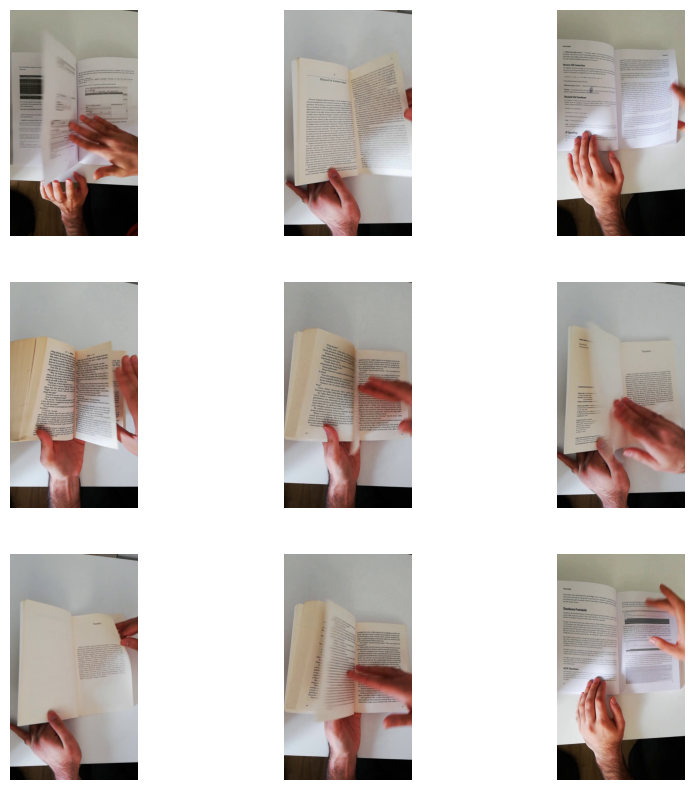

In [19]:
plot_random_images(predicted_noflip_images)

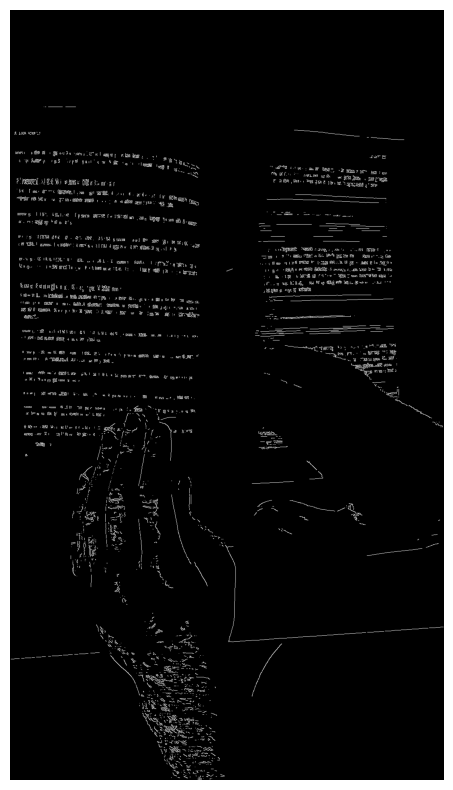

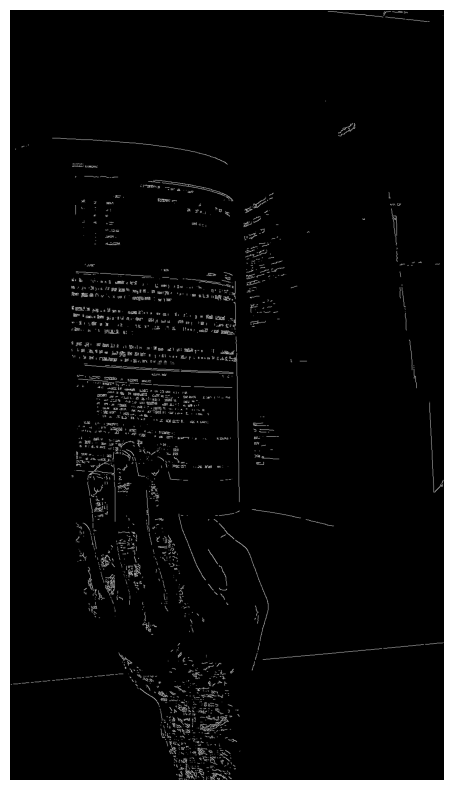

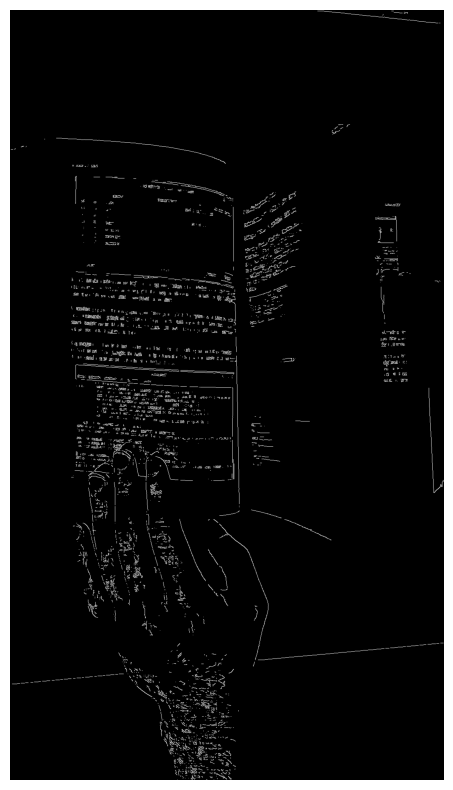

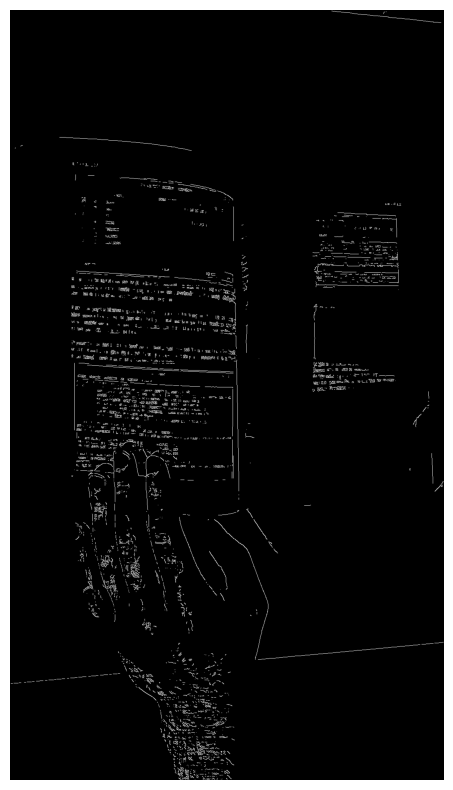

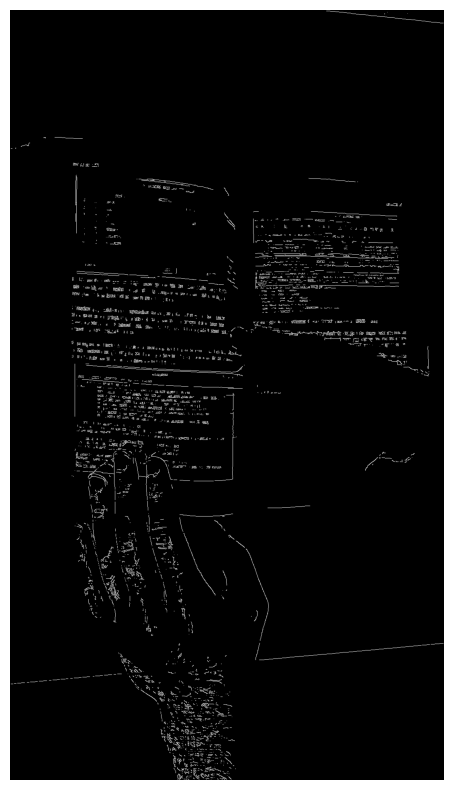

In [20]:
# detect contours

for img in predicted_noflip_images[:5]:
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.Canny(img, 50, 100)
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # make it red
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

In [21]:
def preprocess_predicted_noflip_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.Canny(img, 100, 200)
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # make it red
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
  img = cv2.resize(img, (224, 224))
  img = img / 255
  return img

preprocessed_predicted_noflip_imgs = [
    preprocess_predicted_noflip_image(img) for img in predicted_noflip_images
]

In [22]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [23]:
import pytesseract as pt
from PIL import Image

def ocr(img):
  img = Image.fromarray(img).convert('L')
  text = pt.image_to_string(img)
  return text

predicted_texts = [ocr(img) for img in preprocessed_predicted_noflip_imgs]

predicted_texts[:5]

['\x0c', '\x0c', '\x0c', '\x0c', '\x0c']

In [24]:
!python -m pip install paddlepaddle
!pip install "paddleocr>=2.0.1"

from paddleocr import PaddleOCR, draw_ocr

In [25]:
model = PaddleOCR(use_angle_cls=True, lang='en')

img = predicted_noflip_images[0]

result = model.ocr(img, cls=True)

for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2024/11/07 15:00:52] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c